In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBBSSBSS'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.1+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='SBBSSBSS'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1905.9| 42.4167|-105.3667|       PRCP|USC00483073|     0|[80 4B 80 4B 00 0...|1953.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       PRCP|USC00483073|     0|[00 00 00 00 00 0...|1954.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       PRCP|USC00483073|     0|[00 00 00 00 00 0...|1955.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       PRCP|USC00483073|     0|[00 00 00 00 00 0...|1956.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       PRCP|USC00483073|     0|[00 00 00 00 00 0...|1957.0|SBBSSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



## Convolution

In [8]:
from numpy_pack import unpackArray as _unpackArray
from numpy import linalg as LA

def conv(a, i):
    r = copy(a)
    for _ in range(i):
        a = hstack((a[1:], a[:1]))
        r += a
    return hstack((r[-i/2:], r[:-i/2])) / (i + 1)

def unpackArray(*args):
    res = _unpackArray(*args)
    return conv(res, 40)

In [9]:
# compute STAT['PRCP'] again
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

meas = 'PRCP'
data=df.rdd.map(lambda row: unpackArray(row['vector'],np.float16))
#get very basic statistics
STAT[meas]=computeOverAllDist(data)   # Compute the statistics 

# compute covariance matrix
OUT=computeCov(data)

#find PCA decomposition
eigval,eigvec=LA.eig(OUT['Cov'])

# collect all of the statistics in STAT[meas]
STAT[meas]['eigval']=eigval
STAT[meas]['eigvec']=eigvec
STAT[meas].update(OUT)

shape of E= (365,) shape of NE= (365,)


### Create a matrix with all of the series

In [10]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2563, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

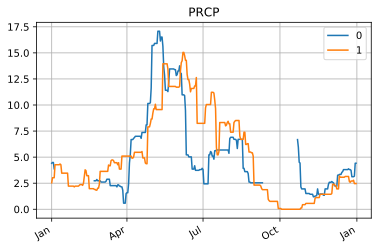

In [11]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

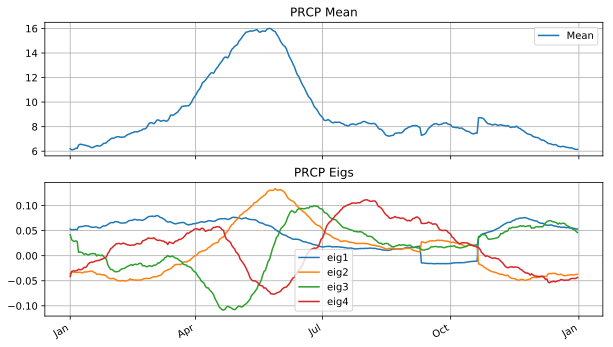

In [12]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
savefig('r_figures/PRCP_mean_eigs.svg')

### plot the percent of residual variance on average

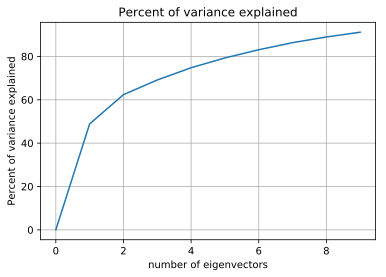

In [13]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [14]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.262409903503
residual normalized norm  after mean + top eigs: [ 0.65659888  0.65638873  0.63384583  0.63105649]


In [15]:
shape(EigVec)

(365, 4)

In [16]:
reductions

('reduction in var for mean,eig1,eig2,...',
 array([  7.37590096e-01,  -1.14655212e+03,  -7.01671694e-01,
         -7.52665137e+01,  -9.31308296e+00]))

In [17]:
res

array([ 0.2624099 ,  0.65659888,  0.65638873,  0.63384583,  0.63105649])

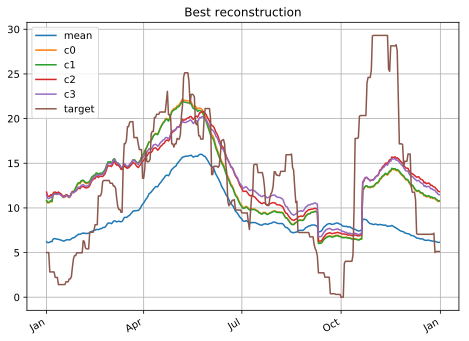

In [18]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [19]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean, v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

In [20]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 0.413522947487 res_1 : 0.474903268194 res_2 : 0.422358255561 res_3 : 0.406071333589
res_mean : 0.260433918947 res_1 : 0.859137019505 res_2 : 0.746217460158 res_3 : 0.688193191277
res_mean : 0.295774419827 res_1 : 0.457826593094 res_2 : 0.457825050559 res_3 : 0.455040548463


In [21]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2563
after filter 2226


In [22]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [23]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [24]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+-------------------+--------------------+--------------------+
|          res_mean|              res_1|               res_2|               res_3|
+------------------+-------------------+--------------------+--------------------+
|0.6406684309967767|0.10504884395203952| 0.10071991325287498| 0.03239879548487998|
|0.6215916617252294|0.14347688340560563| 0.11627316962598805| 0.04396430125616124|
|0.6404557738633374|0.20253833388712728|0.049883367730154594|0.044512623966071606|
|0.4870943649499587|0.10218011812400524|0.058400555223288984| 0.04517549719518878|
+------------------+-------------------+--------------------+--------------------+
only showing top 4 rows



/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


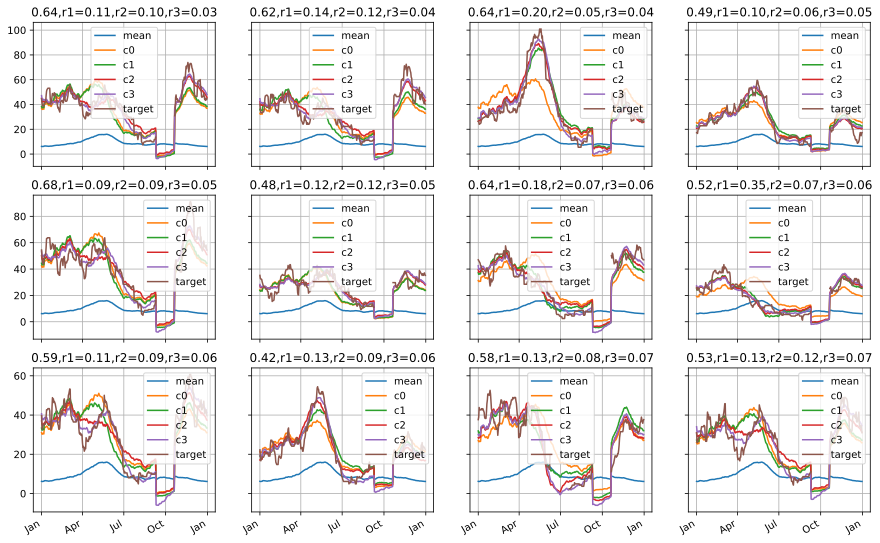

In [25]:
plot_recon_grid(rows)

In [26]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+------------------+------------------+-----------------+
|           res_mean|             res_1|             res_2|            res_3|
+-------------------+------------------+------------------+-----------------+
|0.05252843072225996| 40.33246655263535|11.946216608186537|8.984037862554986|
|0.15533577432847584|3.6941967206355923| 5.652573776116048|5.164098659996608|
| 0.1088690934397094|2.5157051260722456|3.9675692200398154|4.699637396443346|
|0.14630401821419298|1.0514306971638518| 4.527406843897233| 4.64901529689342|
+-------------------+------------------+------------------+-----------------+
only showing top 4 rows



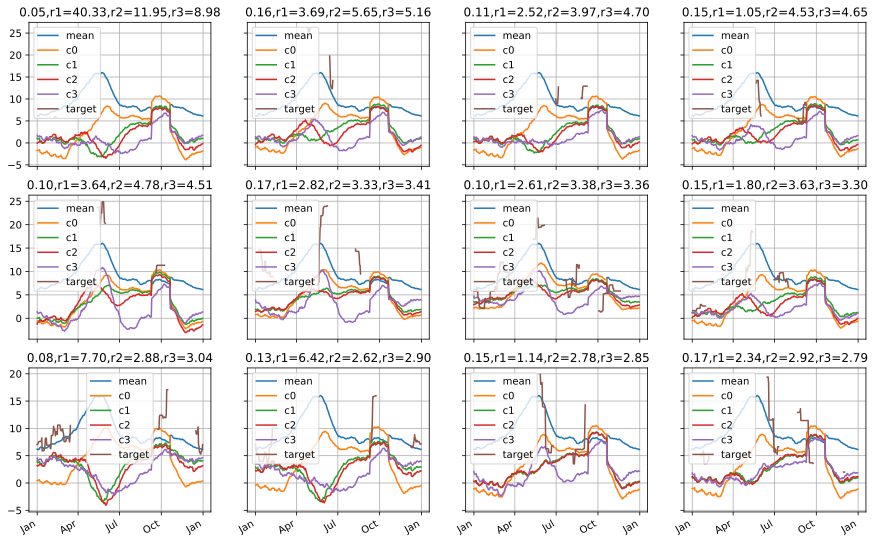

In [27]:
plot_recon_grid(rows)

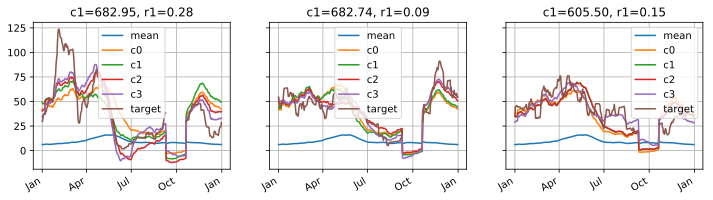

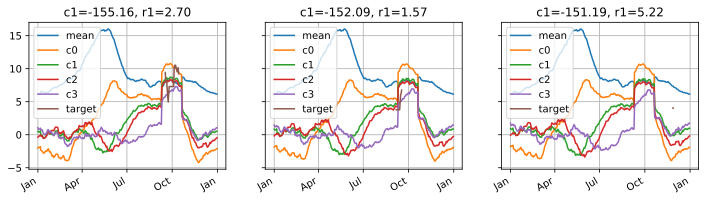

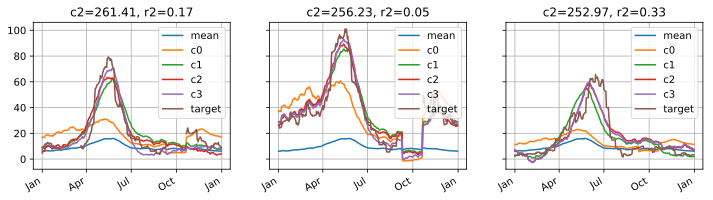

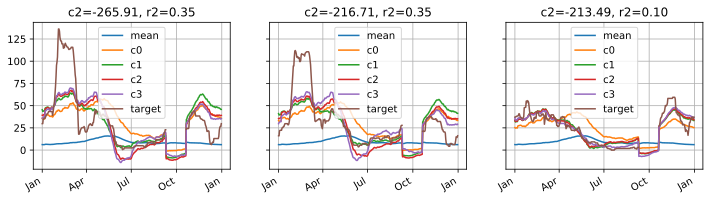

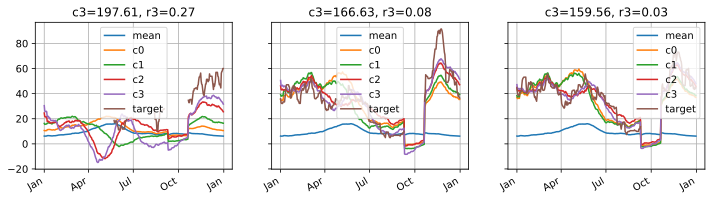

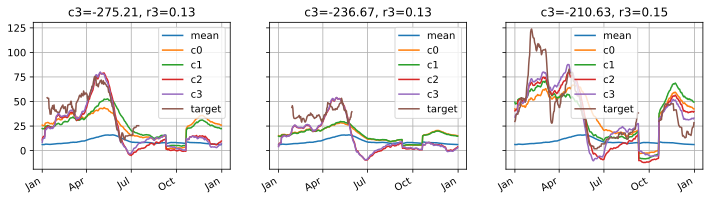

In [28]:
def plot_recon_grid_3(rows, column_n=3, figsize=(12,3), title=""):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(1, column_n, sharex='col', sharey='row',figsize=figsize);
    for i in range(column_n):
        row=rows[i]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[i], Title=title.format(**row.asDict()),interactive=False)
    return None

for i in range(1, 4):
    i = str(i)
    plot_recon_grid_3(df3.sort('coeff_' + i, ascending=False).take(3), title='c'+i+'={coeff_'+i+':.2f}, r'+i+'={res_'+i+':.2f}')
    savefig('r_figures/PRCP_grid_pos_coeff'+i+'.svg')
    plot_recon_grid_3(df3.sort('coeff_' + i, ascending=True).take(3), title='c'+i+'={coeff_'+i+':.2f}, r'+i+'={res_'+i+':.2f}')
    savefig('r_figures/PRCP_grid_neg_coeff'+i+'.svg')

In [29]:
sqlContext.registerDataFrameAsTable(df3,'weather')

In [30]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

In [31]:
for i in range(1, 4):
    i = str(i)
    year_station_table = sqlContext.sql('select station, year, coeff_'+i+' from weather').toPandas().pivot(index='year', columns='station', values='coeff_'+i)
    mean_by_year=np.nanmean(year_station_table,axis=1)
    mean_by_station=np.nanmean(year_station_table,axis=0)
    tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
    tbl_minus_station = year_station_table-mean_by_station

    print '** coeff_'+i+' **'
    print 'total RMS                    = ',RMS(year_station_table)
    print 'RMS removing mean-by-station = ',RMS(tbl_minus_station), ', fraction explained =', (RMS(year_station_table) - RMS(tbl_minus_station)) / RMS(year_station_table) * 100
    print 'RMS removing mean-by-year    = ',RMS(tbl_minus_year), ', fraction explained =', (RMS(year_station_table) - RMS(tbl_minus_year)) / RMS(year_station_table) * 100
    print

** coeff_1 **
total RMS                    =  105.01855224
RMS removing mean-by-station =  57.303438757 , fraction explained = 45.4349374138
RMS removing mean-by-year    =  90.5520063323 , fraction explained = 13.7752288519

** coeff_2 **
total RMS                    =  60.6492657721
RMS removing mean-by-station =  52.2347873505 , fraction explained = 13.8739988266
RMS removing mean-by-year    =  52.2600973837 , fraction explained = 13.8322670219

** coeff_3 **
total RMS                    =  45.8879940114
RMS removing mean-by-station =  43.6733582346 , fraction explained = 4.8261769216
RMS removing mean-by-year    =  38.4352589105 , fraction explained = 16.2411438142



## Plot on a map

In [38]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [35]:
pdf = df3.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", 'coeff_1': "mean"}).toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
62,US1WYCR0001,41.8991,-106.2002,2001.0,2,-144.654822
59,US1WYCR0004,41.6524,-106.4101,2283.9,8,4.680034


In [41]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(coeff_1)'
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

print get_color(_min)
print get_color(_max)

#000080
#800000


In [42]:
min_lat,max_lat,min_long,max_long = box = (pdf.latitude.min(), pdf.latitude.max(), pdf.longitude.min(), pdf.longitude.max())

center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(800*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4, tag=row.station, 
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

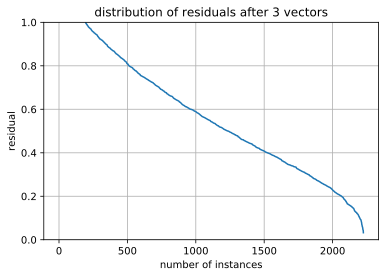

In [32]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [33]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [34]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.5M	../../Data/Weather/US_Weather_SBBSSBSS.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SBBSSBSS_PRCP.parquet
2.3M	../../Data/Weather/decon_SBBSSBSS_SNWD.parquet
